# Group assignment DL - Accent classification

## Data pre-processing

In [1]:
# %pip install torch
# %pip install -r requirements.txt # uncomment when all required libraries are defined

import os
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


-------------

# Start here

In [61]:
def build_metadata(data_dir: str):
    """
    Walk through data_dir and collect file paths, accents, and genders.
    """
    records = []
    for root, _, files in os.walk(data_dir):
        for fname in sorted(files):
            if fname.lower().endswith(".wav"):
                path = os.path.join(root, fname)
                accent = int(fname[0])          # '1'–'5'
                gender = fname[1].lower()       # 'm' or 'f'
                records.append({"path": path, "accent": accent, "gender": gender})
    return pd.DataFrame(records)

In [62]:
import os
import torchaudio
import torch
import torchaudio.transforms as T

# Set target sample rate (e.g., 16000 Hz)
target_sr = 16000

# Directory containing the WAV files
wav_dir = '/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train'  # Replace with your directory path

# Get list of WAV files in the directory
wav_files = [os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith('.wav')]

# Define MFCC transform
mfcc_transform = T.MFCC(sample_rate=target_sr, n_mfcc=40)

# Function to load and preprocess a single WAV file into MFCCs
def load_and_preprocess(wav_path, target_sr, mfcc_transform):
    # Load the WAV file
    waveform, original_sr = torchaudio.load(wav_path)
    
    # Resample if the original sample rate differs from the target
    if original_sr != target_sr:
        resampler = T.Resample(original_sr, target_sr)
        waveform = resampler(waveform)
    
    # Convert stereo to mono by averaging the channels
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    # else, it's already (1, num_samples)
    
    # Apply MFCC transform
    mfcc = mfcc_transform(waveform)  # shape: (1, num_mfcc, num_frames)
    
    # Squeeze the channel dimension and transpose
    mfcc = mfcc.squeeze(0).T  # shape: (num_frames, num_mfcc)
    
    return mfcc

# Load and preprocess all WAV files into a list of MFCC tensors
audio_mfccs = [load_and_preprocess(wav_file, target_sr, mfcc_transform) for wav_file in wav_files]

# Save the list of MFCC tensors to a file
output_file = 'audio_mfccs.pt'
torch.save(audio_mfccs, output_file)

print(f"Loaded {len(audio_mfccs)} audio samples' MFCCs and saved to '{output_file}'")

/Users/bramdewaal/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Loaded 3166 audio samples' MFCCs and saved to 'audio_mfccs.pt'


In [63]:
print(len(audio_mfccs))
print(audio_mfccs[0].shape)
print(audio_mfccs[1].shape)
print(audio_mfccs[2].shape)
print(audio_mfccs[0].dtype)

3166
torch.Size([208, 40])
torch.Size([335, 40])
torch.Size([444, 40])
torch.float32


In [64]:
audio_tensor = torch.load('audio_tensors.pt')

print(len(audio_tensor))
print(audio_tensor[0].shape)
print(audio_tensor[1].shape)
print(audio_tensor[2].shape)
print(audio_tensor[0].dtype)

3166
torch.Size([41400])
torch.Size([66901])
torch.Size([88746])
torch.float32


In [65]:
wav_dir = '/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train'


df_meta = build_metadata(wav_dir)  
print(df_meta) 

                                                   path  accent gender
0     /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       1      f
1     /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       1      f
2     /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       1      f
3     /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       1      f
4     /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       1      f
...                                                 ...     ...    ...
3161  /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       5      m
3162  /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       5      m
3163  /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       5      m
3164  /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       5      m
3165  /Users/bramdewaal/Desktop/Uni/VSC/Deep Learnin...       5      m

[3166 rows x 3 columns]


In [76]:
import torch

# Suppose df_meta['accent'] is [1, 3, 2, 5, …]
all_accents = df_meta['accent'].tolist()

# Convert to a torch.LongTensor
labels = torch.tensor(all_accents, dtype=torch.long)



print(labels.shape)   # → torch.Size([N])
print(labels.dtype)   # → torch.int64



torch.Size([3166])
torch.int64


In [77]:
import torch

# ───────────────────────────────────────────────────
# Build a 4D feature tensor "mfcc_feats" from audio_mfccs
# ───────────────────────────────────────────────────

# Assume:
#   audio_mfccs : list of Tensors [num_frames, n_mfcc]
#   labels      : LongTensor shape [N] with values 0–4

max_frames = 160                   # number of time-frames per example
n_mfcc     = audio_mfccs[0].shape[1]
feat_list  = []

for m in audio_mfccs:
    # m: [num_frames, n_mfcc]
    n_frames = m.size(0)

    # pad or trim to max_frames
    if n_frames < max_frames:
        pad_amt = max_frames - n_frames
        pad     = torch.zeros(pad_amt, n_mfcc)
        m_proc  = torch.cat([m, pad], dim=0)
    else:
        m_proc = m[:max_frames]

    # convert to shape [1, n_mfcc, max_frames]
    #   transpose: [num_frames, n_mfcc] -> [n_mfcc, num_frames]
    #   unsqueeze: add channel dim -> [1, n_mfcc, max_frames]
    feat_list.append(m_proc.T.unsqueeze(0))

# stack into [N, 1, n_mfcc, max_frames]
mfcc_feats = torch.stack(feat_list, dim=0)

print("mfcc_feats shape:", mfcc_feats.shape)  # should be [N, 1, 40, 160]
print("labels  shape:", labels.shape)         # should be [N]

mfcc_feats shape: torch.Size([3166, 1, 40, 160])
labels  shape: torch.Size([3166])


In [79]:
from torch.utils.data import TensorDataset

# Suppose `mfcc_feats` is your precomputed feature tensor of shape [N, 1, n_mfcc, T]
# and `labels` is your LongTensor of shape [N] with values 0–4.

dataset = TensorDataset(mfcc_feats, labels)
print(dataset.__len__())
print(dataset[0])

3166
(tensor([[[-6.0048e+02, -6.0355e+02, -6.0355e+02,  ..., -6.0355e+02,
          -6.0355e+02, -6.0355e+02],
         [ 3.6145e+00,  2.4434e-05,  2.4434e-05,  ...,  2.4434e-05,
           2.4434e-05,  2.4434e-05],
         [ 2.1104e+00, -1.9695e-06, -1.9695e-06,  ..., -1.9695e-06,
          -1.9695e-06, -1.9695e-06],
         ...,
         [ 4.9243e-01,  6.8209e-05,  6.8209e-05,  ...,  6.8209e-05,
           6.8209e-05,  6.8209e-05],
         [ 2.8180e-01, -1.6886e-04, -1.6886e-04,  ..., -1.6886e-04,
          -1.6886e-04, -1.6886e-04],
         [-4.7854e-01, -1.4969e-04, -1.4969e-04,  ..., -1.4969e-04,
          -1.4969e-04, -1.4969e-04]]]), tensor(1))


In [69]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# 1) Create the dataset
full_ds = TensorDataset(mfcc_feats, labels)

# 2) Split into train/val (80/20)
N     = len(full_ds)
n_val = int(0.2 * N)
n_train = N - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val],
                                generator=torch.Generator().manual_seed(42))

# 3) DataLoaders
batch_size = 32
train_loader_mel = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=0)
val_loader_mel   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, num_workers=0)

In [83]:
print(len(full_ds))

3166


In [84]:
mel_model, mel_history = run_experiment(
    MelCNN2D,
    train_loader=train_loader_mel,
    val_loader=val_loader_mel,
    epochs=10,
    num_classes=5,
    p_dropout=0.3
)


Training MelCNN2D for 10 epochs on mps



Epoch 1/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 1/10  Train ▶ loss=1.6063, acc=0.2341 | Val   ▶ loss=1.5972, acc=0.2480 | Time=1.3s


Epoch 2/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 2/10  Train ▶ loss=1.6020, acc=0.2448 | Val   ▶ loss=1.5974, acc=0.2148 | Time=1.1s


Epoch 3/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 3/10  Train ▶ loss=1.6052, acc=0.2321 | Val   ▶ loss=1.5961, acc=0.2543 | Time=1.1s


Epoch 4/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 4/10  Train ▶ loss=1.6033, acc=0.2298 | Val   ▶ loss=1.5911, acc=0.2654 | Time=1.1s


Epoch 5/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 5/10  Train ▶ loss=1.6003, acc=0.2432 | Val   ▶ loss=1.5953, acc=0.2306 | Time=1.1s


Epoch 6/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 6/10  Train ▶ loss=1.6018, acc=0.2321 | Val   ▶ loss=1.5916, acc=0.2480 | Time=1.1s


Epoch 7/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 7/10  Train ▶ loss=1.5975, acc=0.2381 | Val   ▶ loss=1.5904, acc=0.2780 | Time=1.1s


Epoch 8/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 8/10  Train ▶ loss=1.6019, acc=0.2313 | Val   ▶ loss=1.5906, acc=0.2559 | Time=1.1s


Epoch 9/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 9/10  Train ▶ loss=1.6027, acc=0.2250 | Val   ▶ loss=1.5931, acc=0.2591 | Time=1.1s


Epoch 10/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 10/10  Train ▶ loss=1.5990, acc=0.2416 | Val   ▶ loss=1.5939, acc=0.2370 | Time=1.1s

Training complete.



---------

# IGNORE FOR NOW

In [24]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell X: Stratified train/val split of your precomputed MFCCs and metadata
# ──────────────────────────────────────────────────────────────────────────────

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# 1) Reload the saved MFCC list and rebuild metadata
audio_mfccs = torch.load("audio_mfccs.pt")        # previously saved list
df_meta     = build_metadata(wav_dir)             # must be in same order

assert len(audio_mfccs) == len(df_meta), \
       "❌ audio_mfccs length must match metadata rows"

# 2) Stratified split on accent (labels 1–5)
df_train, df_val, mfcc_train, mfcc_val = train_test_split(
    df_meta, audio_mfccs,
    test_size=0.2,
    random_state=42,
    stratify=df_meta["accent"]
)

print(f"Train size: {len(df_train)}  |  Val size: {len(df_val)}")

Train size: 2532  |  Val size: 634


In [25]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell X+1: Dataset wrapping precomputed MFCCs for 2D CNN input
# ──────────────────────────────────────────────────────────────────────────────

import torch
from torch.utils.data import Dataset

class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, metadata_df, max_frames=160):
        self.mfccs = mfcc_list
        self.meta  = metadata_df.reset_index(drop=True)
        self.max_frames = max_frames

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        m = self.mfccs[idx]             # [num_frames, n_mfcc]
        n_frames, n_mfcc = m.shape

        # Pad / trim to fixed length
        if n_frames < self.max_frames:
            pad = torch.zeros(self.max_frames - n_frames, n_mfcc)
            m = torch.cat([m, pad], dim=0)
        else:
            m = m[:self.max_frames]

        # Format for 2D CNN: [1, n_mfcc, max_frames]
        x = m.T.unsqueeze(0)
        x = (x - x.mean()) / (x.std() + 1e-6)

        # Label 0–4
        y = torch.tensor(self.meta.loc[idx, "accent"] - 1, dtype=torch.long)
        return x, y

In [26]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell X+2: Build separate train & val DataLoaders for Mel CNN
# ──────────────────────────────────────────────────────────────────────────────

batch_size  = 32
max_frames  = 160  # adjust if your MFCC produces a different frame count

# Train dataset + loader
train_ds_mel = MFCCDataset(mfcc_train, df_train, max_frames=max_frames)
train_loader_mel = DataLoader(
    train_ds_mel,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,       # single-process on macOS
    pin_memory=False
)

# Val dataset + loader
val_ds_mel   = MFCCDataset(mfcc_val, df_val, max_frames=max_frames)
val_loader_mel = DataLoader(
    val_ds_mel,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Mel train batches: {len(train_loader_mel)}, val batches: {len(val_loader_mel)}")

Mel train batches: 80, val batches: 20


In [39]:
class MelCNN2D(nn.Module):
    def __init__(self, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # x: [B,1,n_mels,time]
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/2 × time/2
            nn.Conv2d(32,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/4 × time/4
            nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # collapse to [B,128,1,1]
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feat = self.net(x)  # [B,128]
        return self.classifier(feat)


In [40]:
import time
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()

def run_experiment(model_cls, train_loader, val_loader, epochs=10, **model_kwargs):
    """
    Trains model_cls for `epochs` epochs on train_loader, validates on val_loader.
    model_kwargs → model __init__; epochs is handled here.
    """
    model = model_cls(**model_kwargs).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    print(f"\nTraining {model_cls.__name__} for {epochs} epochs on {device}\n")
    for epoch in range(1, epochs + 1):
        start = time.time()

        # —— TRAINING —— 
        model.train()
        t_loss = correct = count = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [TRAIN]", leave=False)
        for x, y in train_bar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            t_loss    += loss.item() * x.size(0)
            preds     = logits.argmax(1)
            correct   += (preds == y).sum().item()
            count     += x.size(0)
            train_bar.set_postfix(batch_loss=loss.item())

        train_loss = t_loss / count
        train_acc  = correct / count

        # —— VALIDATION —— 
        model.eval()
        v_loss = correct = count = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [  VAL ]", leave=False)
        with torch.no_grad():
            for x, y in val_bar:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                v_loss  += loss.item() * x.size(0)
                preds   = logits.argmax(1)
                correct += (preds == y).sum().item()
                count   += x.size(0)
                val_bar.set_postfix(batch_loss=loss.item())

        val_loss = v_loss / count
        val_acc  = correct / count

        # record history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        elapsed = time.time() - start
        print(f"[{model_cls.__name__}] Epoch {epoch}/{epochs}  "
              f"Train ▶ loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val   ▶ loss={val_loss:.4f}, acc={val_acc:.4f} | "
              f"Time={elapsed:.1f}s")

    print("\nTraining complete.\n")
    return model, history

In [41]:
mel_model, mel_history = run_experiment(
    MelCNN2D,
    train_loader=train_loader_mel,
    val_loader=val_loader_mel,
    epochs=10,          # now correctly handled here
    num_classes=5,
    p_dropout=0.3
)


Training MelCNN2D for 10 epochs on mps



Epoch 1/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 1/10  Train ▶ loss=1.5675, acc=0.2812 | Val   ▶ loss=1.4785, acc=0.4069 | Time=2.5s


Epoch 2/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 2/10  Train ▶ loss=1.4004, acc=0.4040 | Val   ▶ loss=1.4720, acc=0.3912 | Time=1.3s


Epoch 3/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 3/10  Train ▶ loss=1.2830, acc=0.4621 | Val   ▶ loss=1.2252, acc=0.4527 | Time=1.2s


Epoch 4/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 4/10  Train ▶ loss=1.2062, acc=0.5122 | Val   ▶ loss=1.1404, acc=0.5536 | Time=1.2s


Epoch 5/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 5/10  Train ▶ loss=1.1351, acc=0.5454 | Val   ▶ loss=1.4346, acc=0.4732 | Time=1.2s


Epoch 6/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 6/10  Train ▶ loss=1.0602, acc=0.5770 | Val   ▶ loss=1.0717, acc=0.5647 | Time=1.3s


Epoch 7/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 7/10  Train ▶ loss=1.0805, acc=0.5920 | Val   ▶ loss=1.1578, acc=0.5110 | Time=1.3s


Epoch 8/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 8/10  Train ▶ loss=0.9379, acc=0.6556 | Val   ▶ loss=0.8723, acc=0.6483 | Time=1.2s


Epoch 9/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 9/10  Train ▶ loss=0.9213, acc=0.6568 | Val   ▶ loss=1.2291, acc=0.5536 | Time=1.3s


Epoch 10/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 10/10  Train ▶ loss=0.8722, acc=0.6765 | Val   ▶ loss=0.7913, acc=0.7161 | Time=1.2s

Training complete.



-------------

In [42]:
# After loading mfcc_list and df_meta:

df_train, df_val, mfcc_train, mfcc_val = train_test_split(
    df_meta, mfcc_list,
    test_size=0.2,
    random_state=42,
    stratify=df_meta["accent"]
)
# Build two MFCCDataset instances: one from mfcc_train/df_train, one from mfcc_val/df_val

In [43]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# 1) Load your precomputed MFCCs and metadata
audio_mfccs = torch.load("audio_mfccs.pt")  # list of [num_frames, n_mfcc] tensors
df_meta     = build_metadata(wav_dir)       # your original DataFrame in same order

# sanity check
assert len(audio_mfccs) == len(df_meta), "Features and metadata must align"

# 2) Stratified split on accents *and* split the list in parallel
df_train, df_val, mfcc_train, mfcc_val = train_test_split(
    df_meta, audio_mfccs,
    test_size=0.2,
    random_state=42,
    stratify=df_meta["accent"]
)

# 3) Wrap each split into a Dataset
class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, metadata_df, max_frames=160):
        self.mfccs = mfcc_list
        self.meta  = metadata_df.reset_index(drop=True)
        self.max_frames = max_frames

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        m = self.mfccs[idx]             # [num_frames, n_mfcc]
        n_frames, n_mfcc = m.shape
        # pad/trim
        if n_frames < self.max_frames:
            pad = torch.zeros(self.max_frames - n_frames, n_mfcc)
            m = torch.cat([m, pad], dim=0)
        else:
            m = m[:self.max_frames]
        # format for 2D CNN: [1, n_mfcc, max_frames]
        x = m.T.unsqueeze(0)
        x = (x - x.mean())/(x.std()+1e-6)
        y = torch.tensor(self.meta.loc[idx, "accent"] - 1, dtype=torch.long)
        return x, y

# 4) Create train & val Datasets
max_frames = 160  # adjust if your hop-length/frame-count differs
train_ds_mel = MFCCDataset(mfcc_train, df_train, max_frames=max_frames)
val_ds_mel   = MFCCDataset(mfcc_val,   df_val,   max_frames=max_frames)

# 5) Build separate DataLoaders
batch_size = 32
train_loader_mel = DataLoader(train_ds_mel, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_mel   = DataLoader(val_ds_mel,   batch_size=batch_size, shuffle=False, num_workers=0)

# 6) Now call run_experiment with distinct loaders
mel_model, mel_history = run_experiment(
    MelCNN2D,
    train_loader=train_loader_mel,
    val_loader=val_loader_mel,
    epochs=10,         # or 5 for quicker debug
    num_classes=5,
    p_dropout=0.3
)


Training MelCNN2D for 10 epochs on mps



Epoch 1/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 1/10  Train ▶ loss=1.5206, acc=0.3286 | Val   ▶ loss=1.3953, acc=0.3833 | Time=1.3s


Epoch 2/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 2/10  Train ▶ loss=1.3315, acc=0.4234 | Val   ▶ loss=1.2607, acc=0.4842 | Time=1.2s


Epoch 3/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 3/10  Train ▶ loss=1.2453, acc=0.4810 | Val   ▶ loss=1.3372, acc=0.4132 | Time=1.2s


Epoch 4/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 4/10  Train ▶ loss=1.1723, acc=0.5213 | Val   ▶ loss=1.0845, acc=0.5994 | Time=1.2s


Epoch 5/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 5/10  Train ▶ loss=1.1042, acc=0.5671 | Val   ▶ loss=1.0948, acc=0.5300 | Time=1.2s


Epoch 6/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 6/10  Train ▶ loss=1.0272, acc=0.6106 | Val   ▶ loss=1.4262, acc=0.4432 | Time=1.2s


Epoch 7/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 7/10  Train ▶ loss=0.9685, acc=0.6224 | Val   ▶ loss=0.9859, acc=0.6230 | Time=1.2s


Epoch 8/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 8/10  Train ▶ loss=0.9071, acc=0.6746 | Val   ▶ loss=1.9540, acc=0.4401 | Time=1.3s


Epoch 9/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 9/10  Train ▶ loss=0.9210, acc=0.6588 | Val   ▶ loss=1.2746, acc=0.4700 | Time=1.2s


Epoch 10/10 [TRAIN]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/10 [  VAL ]:   0%|          | 0/20 [00:00<?, ?it/s]

[MelCNN2D] Epoch 10/10  Train ▶ loss=0.8267, acc=0.6884 | Val   ▶ loss=0.8090, acc=0.7177 | Time=1.3s

Training complete.



In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import torch.nn as nn

class RawCNN1D(nn.Module):
    def __init__(self, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # Conv + aggressive pooling to cut 80k → 5k → 1
            nn.Conv1d(1, 32, kernel_size=9, padding=4), nn.ReLU(),
            nn.MaxPool1d(4),  # 80k→20k
            nn.Conv1d(32, 64, kernel_size=9, padding=4), nn.ReLU(),
            nn.MaxPool1d(4),  # 20k→5k
            nn.Conv1d(64, 128, kernel_size=9, padding=4), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # 5k→1
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: [B,1,T]
        feat = self.net(x)       # [B,128]
        return self.classifier(feat)


class MelCNN2D(nn.Module):
    def __init__(self, num_epochs, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # x: [B,1,n_mels,time]
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/2 × time/2
            nn.Conv2d(32,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/4 × time/4
            nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # collapse to [B,128,1,1]
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feat = self.net(x)  # [B,128]
        return self.classifier(feat)



In [17]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="Model"):
    """
    history: dict with keys 'train_loss','val_loss','train_acc','val_acc'
             each a list of length = num_epochs
    model_name: string for titles/labels
    """
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Plot Loss
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"],  label="Train Loss")
    plt.plot(epochs, history["val_loss"],    label="Val   Loss")
    plt.title(f"{model_name} Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"],  label="Train Acc")
    plt.plot(epochs, history["val_acc"],    label="Val   Acc")
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

🚀 Using Apple MPS on Apple Silicon: mps
MelCNN2D Epoch 01  Train: 1.089, 0.232 | Val: 1.044, 0.263
MelCNN2D Epoch 02  Train: 1.024, 0.288 | Val: 1.056, 0.253
MelCNN2D Epoch 03  Train: 0.939, 0.363 | Val: 1.081, 0.291
MelCNN2D Epoch 04  Train: 0.869, 0.404 | Val: 0.935, 0.322
MelCNN2D Epoch 05  Train: 0.789, 0.449 | Val: 0.709, 0.522
MelCNN2D Epoch 06  Train: 0.731, 0.484 | Val: 0.667, 0.527
MelCNN2D Epoch 07  Train: 0.673, 0.506 | Val: 0.626, 0.541
MelCNN2D Epoch 08  Train: 0.664, 0.509 | Val: 0.623, 0.516
MelCNN2D Epoch 09  Train: 0.628, 0.527 | Val: 0.968, 0.335
MelCNN2D Epoch 10  Train: 0.596, 0.539 | Val: 0.794, 0.447


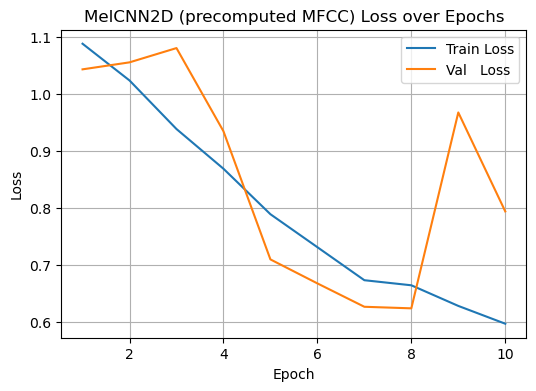

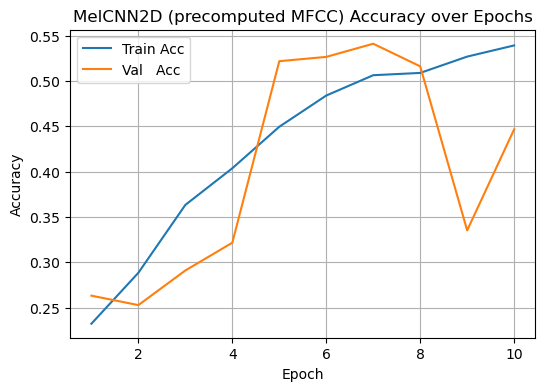

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

# 1) Load your saved MFCC list
mfcc_list = torch.load("audio_mfccs.pt")   # list of Tensors [num_frames, n_mfcc]

# 2) Rebuild metadata so you know each file's accent
#    (must match the order you used when saving)
wav_dir = "/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train"
df_meta = build_metadata(wav_dir)  # as before, yields DataFrame in the same order

assert len(mfcc_list) == len(df_meta), "Metadata & features must align"


import torch

# Cross-platform device selection
try:
    import torch_directml
    device = torch_directml.device()
    print("🚀 Using DirectML on AMD GPU:", device)
except ImportError:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🚀 Using Apple MPS on Apple Silicon:", device)
    else:
        device = torch.device("cpu")
        print("⚠️  Falling back to CPU:", device)
# 3) Create a Dataset that pads/trims MFCCs to a fixed frame count
class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, metadata_df, max_frames=160):
        self.mfccs = mfcc_list
        self.meta  = metadata_df.reset_index(drop=True)
        self.max_frames = max_frames
        
    def __len__(self):
        return len(self.mfccs)
    
    def __getitem__(self, idx):
        m = self.mfccs[idx]            # [num_frames, n_mfcc]
        n_frames, n_mfcc = m.shape
        
        # pad or trim to max_frames
        if n_frames < self.max_frames:
            pad_amt = self.max_frames - n_frames
            pad = torch.zeros(pad_amt, n_mfcc)
            m = torch.cat([m, pad], dim=0)
        else:
            m = m[:self.max_frames]
        
        # now m is [max_frames, n_mfcc]
        x = m.T                       # → [n_mfcc, max_frames]
        x = x.unsqueeze(0)            # → [1, n_mfcc, max_frames]
        
        # normalize
        x = (x - x.mean())/(x.std()+1e-6)
        
        # label (0–4)
        y = self.meta.loc[idx, "accent"] - 1
        return x, torch.tensor(y, dtype=torch.long)

# 4) Instantiate Dataset + DataLoader
# Choose max_frames so it covers most of your signals (e.g., ~160)
ds_mfcc = MFCCDataset(mfcc_list, df_meta, max_frames=160)
loader_mfcc = DataLoader(ds_mfcc, batch_size=32, shuffle=True, num_workers=0)

# 5) Train with your MelCNN2D
mel_model, mel_history = run_experiment(
    MelCNN2D,
    train_loader=loader_mfcc,
    val_loader=loader_mfcc,    # replace with a proper val split if you have one

    num_classes=5,
    p_dropout=0.3
)

# 6) Plot curves
plot_training_curves(mel_history, model_name="MelCNN2D (precomputed MFCC)")

-----------

In [6]:
df = build_metadata("/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train") # Training dataframe based on accent & gender metadata
